In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from typing import List, Dict, Tuple, Optional, Union
import pandas as pd
import sys
import os
from matplotlib import colors
from skimage.metrics import structural_similarity as ssim
from scipy.signal import correlate2d, find_peaks
from scipy.ndimage import gaussian_filter
import random
import importlib
from tqdm import tqdm
import h5py
import re
import json
from collections import defaultdict

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))
import utils.ptychosaxsNN_utils as ptNN_U
importlib.reload(ptNN_U)
from utils.model_comparer import ModelComparer

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/models/')))

ModelComparer class initialized successfully!
Using device: cuda
Loading data from: /net/micdata/data2/12IDC/ptychosaxs/batch_mode/hkl/LatticeClathII_Probe256x256_ZCB_9_3D__Noise_hkl311/sim_ZCB_9_3D_S5065_N1_steps4_dp256.h5
<KeysViewHDF5 ['convDP', 'indices_ik', 'pinholeDP', 'pinholeDP_raw_FFT', 'probe', 'probe_center_xy', 'rotation_angles']>
Loaded 16 diffraction patterns
Pattern shapes - conv_DPs: (16, 256, 256), ideal_DPs: (16, 256, 256)
Using index 10


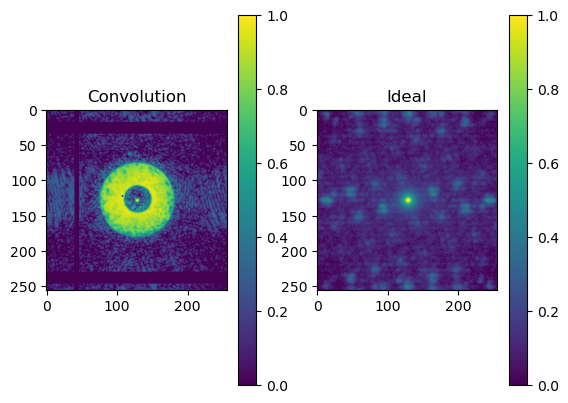

In [12]:
# Initialize the comparer
comparer = ModelComparer()

probe_sizes=[256]#,256]#,128]
lattice_types=['ClathII']#,'SC']#,'ClathII']
unet_statuses=['Unet']#,'no_Unet']#,'no_Unet']#,'Unet']#,'no_Unet']
loss_functions=['pearson_loss']#,'L1','L2']#,'L1','L2']
noise_statuses=['Noise']#,'noNoise']#,'Noise']
files=[10]#2,10,25,50,100,150,200,250,300,400,500]
base_path="/net/micdata/data2/12IDC/ptychosaxs/"
model_list=[base_path + f'batch_mode_250/trained_model/best_model_Lattice{lattice_type}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise_status}_sim_ZCB_9_3D_S5065_N600_steps4_dp256_{unet_status}_epoch_{f}_{loss_function}_symmetry_0.0.pth' for f in files for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
model_list_info =[f'Lattice{lattice_type}_Probe{probe_size}x{probe_size}_{noise_status}_{unet_status}_{loss_function}' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]


model_configs = {
    'iterations': files,
    'models': {
        'pearson_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        'pearson_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
        'L1_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth',
        'L1_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0.pth',
        'L2_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth',
        'L2_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L2_symmetry_0.0.pth',
    }
}

print("ModelComparer class initialized successfully!")
print(f"Using device: {comparer.device}")


# Load the input data
mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
hr,kr,lr=3,1,1#1,1,0
h5file_data=f'/net/micdata/data2/12IDC/ptychosaxs/batch_mode/hkl/LatticeClathII_Probe256x256_ZCB_9_3D__Noise_hkl{hr}{kr}{lr}/sim_ZCB_9_3D_S5065_N1_steps4_dp256.h5'
# Load data directly from the HDF5 file
print(f"Loading data from: {h5file_data}")

with h5py.File(h5file_data, "r") as h5f:
    # Load convDP and pinholeDP_raw_FFT as conv and ideal diffraction patterns
    conv_DPs = h5f['convDP'][:]  # Shape: (16, 256, 256)
    ideal_DPs = h5f['pinholeDP_raw_FFT'][:]  # Shape: (16, 256, 256)
    
    print(h5f.keys())
    num_patterns = len(conv_DPs)
    print(f"Loaded {num_patterns} diffraction patterns")
    print(f"Pattern shapes - conv_DPs: {conv_DPs.shape}, ideal_DPs: {ideal_DPs.shape}")

# Create dummy probe array (as before)
probe_DPs = np.ones(conv_DPs.shape)  # dummy array for testing network with a probe

# Display a random pattern to verify the data
ri = np.random.randint(0, len(conv_DPs))
ri=10
print(f"Using index {ri}")

dp_pp,_,_ = ptNN_U.preprocess_ZCB_9(conv_DPs[ri],mask)
dp_pp_IDEAL,_,_ = ptNN_U.preprocess_ZCB_9(ideal_DPs[ri],mask=np.ones(dp_pp[0][0].shape))

#%%
# Ensure data is in correct format
dp_pp = comparer.ensure_tensor_format(dp_pp)
dp_pp_IDEAL = comparer.ensure_tensor_format(dp_pp_IDEAL)

fig,ax = plt.subplots(1,2)
im1=ax[0].imshow(dp_pp.squeeze().cpu().numpy())
im2=ax[1].imshow(dp_pp_IDEAL.squeeze().cpu().numpy())
plt.colorbar(im1,ax=ax[0])
plt.colorbar(im2,ax=ax[1])
ax[0].set_title('Convolution')
ax[1].set_title('Ideal')
plt.show()





In [ ]:
comparer.default_peak_sigma = 0.714*2
comparer.default_peak_threshold = 0.265*1.07
comparer.peak_distance_threshold = 12.0
comparer.ideal_peak_smoothing_sigma = 1.0
comparer.percentile_threshold_value = 96.
comparer.output_percentile_threshold_value = comparer.percentile_threshold_value
comparer.use_percentile_threshold = True

Found 33 output peaks vs 41 ideal peaks
Found 29 output peaks vs 41 ideal peaks
Found 31 output peaks vs 41 ideal peaks
Found 31 output peaks vs 41 ideal peaks
Found 33 output peaks vs 41 ideal peaks
Found 35 output peaks vs 41 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1035: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


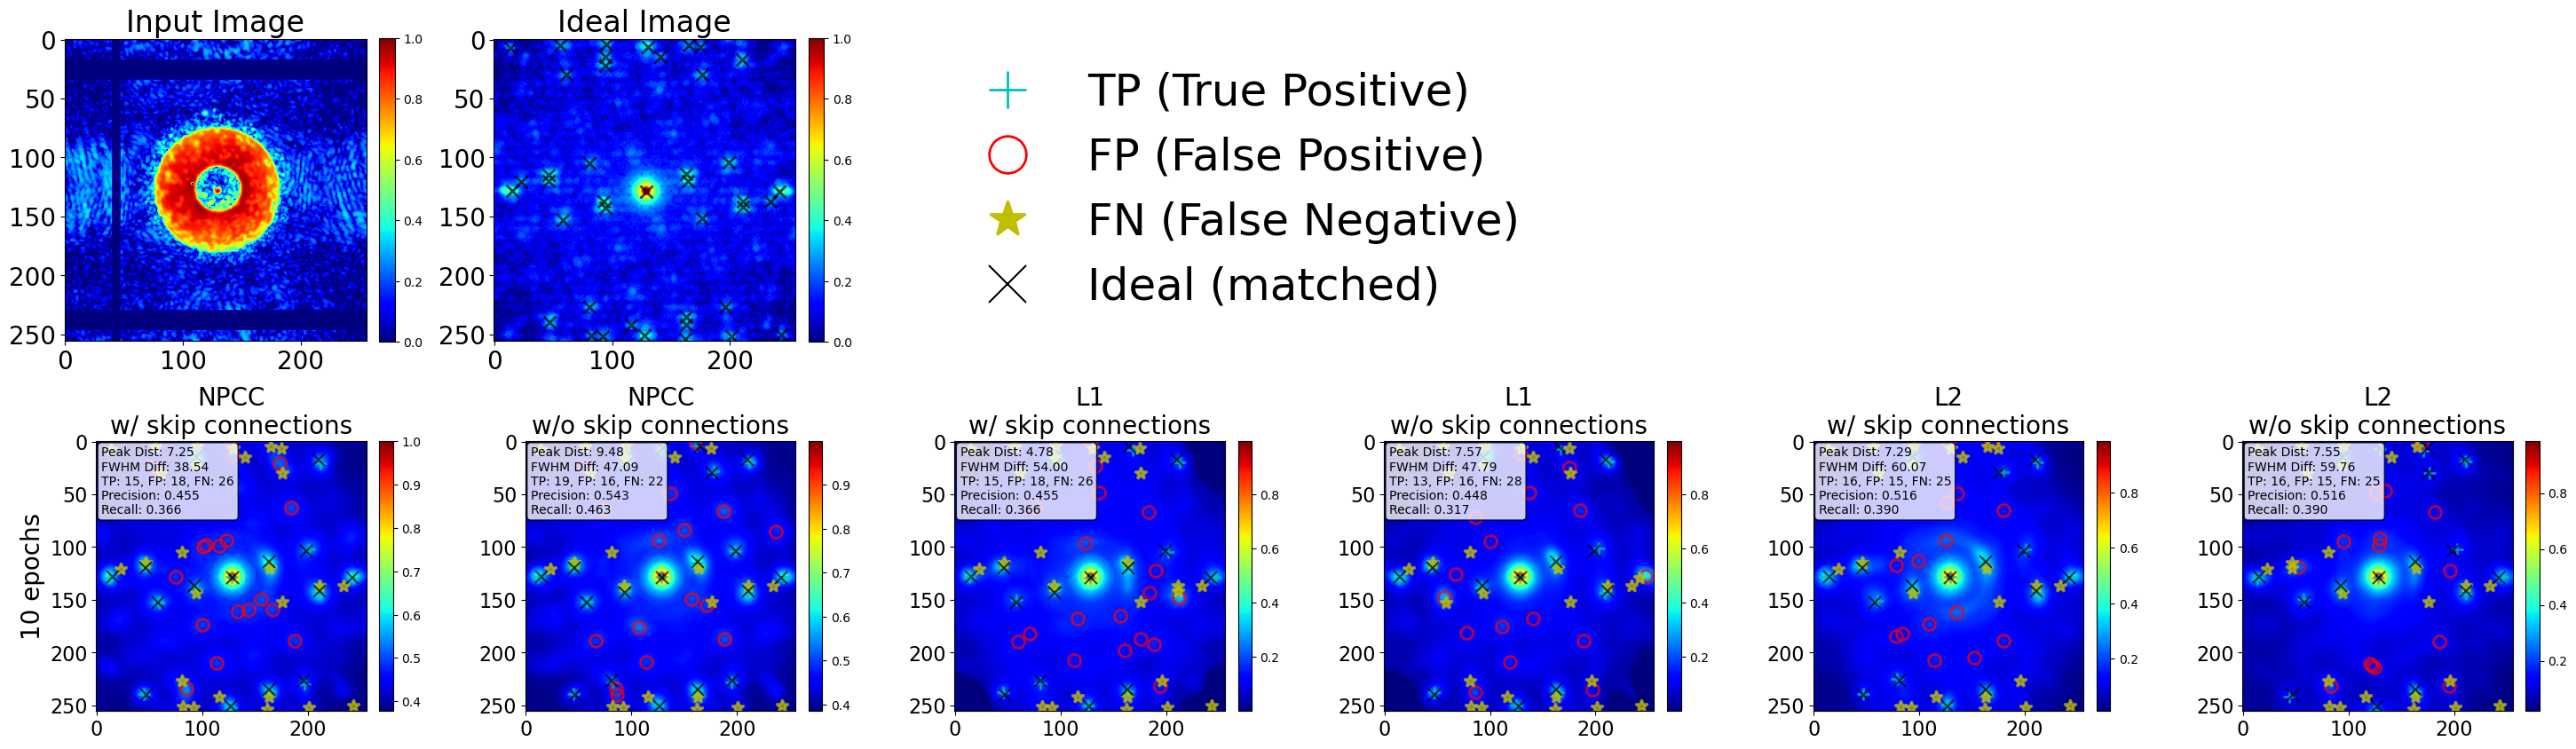

In [ ]:
# Create comparison grid
fig = comparer.create_comparison_grid(
    model_configs=model_configs,
    input_data=dp_pp,
    ideal_data=dp_pp_IDEAL,
    figsize=(15, 15),
    calculate_psnr=False,
    calculate_ssim=False,
    calculate_xcorr=False,
    show_peak_classification=True,
    calculate_peaks=True,
)

In [7]:
# loss_figures = comparer.plot_loss_comparison(
#     data_dir="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/",
#     expected_epochs=[2, 5, 10, 25, 50, 100, 150, 200, 250],
#     expected_losses=['L1', 'L2', 'pearson_loss'],
#     show_normalized=True,
#     show_combined=True,
#     figsize=(16, 12)
# )

--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [2], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0

Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

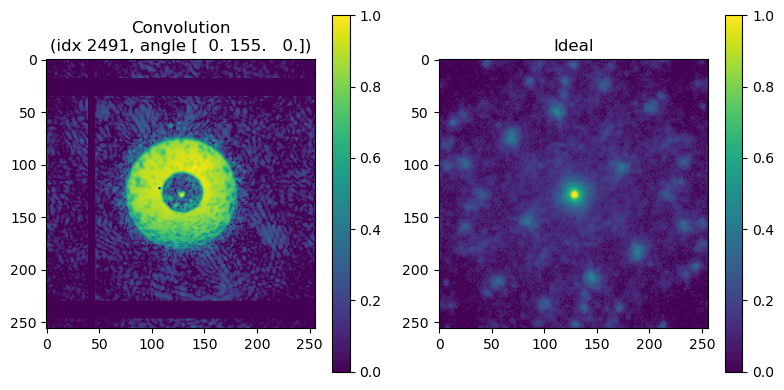

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Found 35 output peaks vs 25 ideal peaks
Found 20 output peaks vs 25 ideal peaks
Found 18 output peaks vs 25 ideal peaks
Found 22 output peaks vs 25 ideal peaks
Found 21 output peaks vs 25 ideal peaks
Found 20 output peaks vs 25 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1035: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


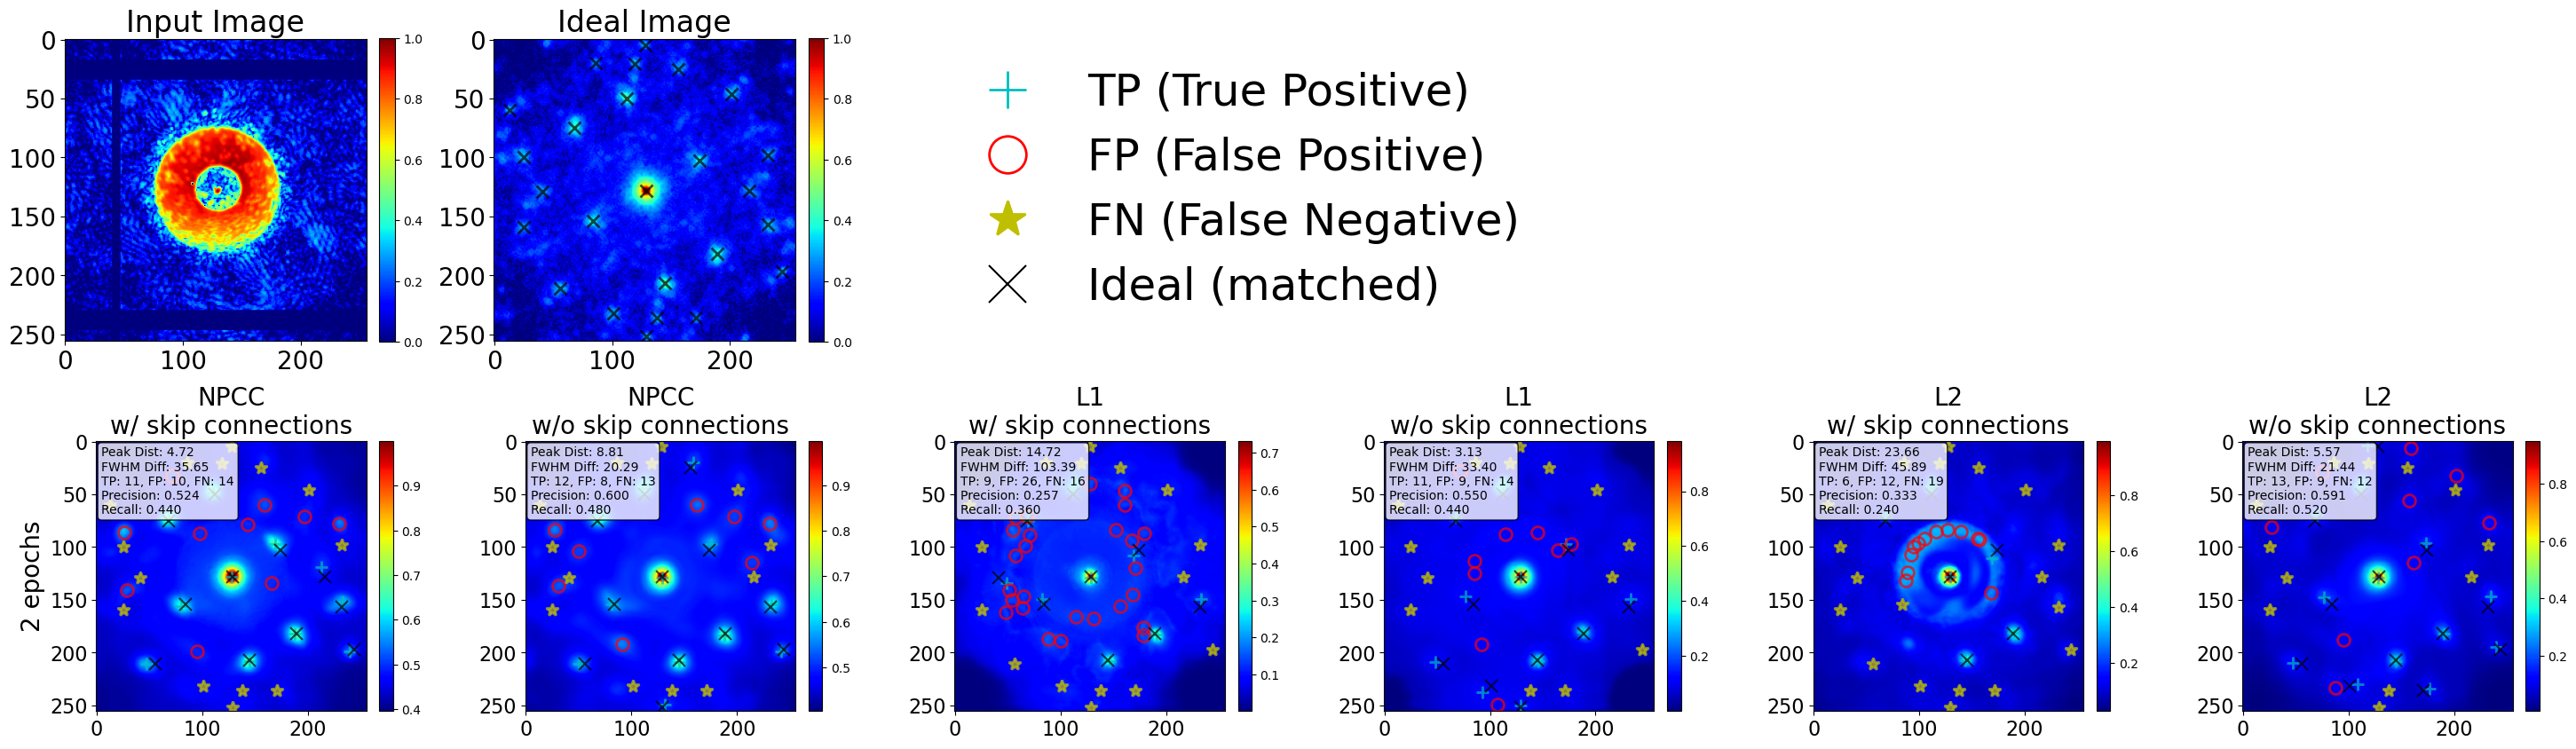

--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [10], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.

Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

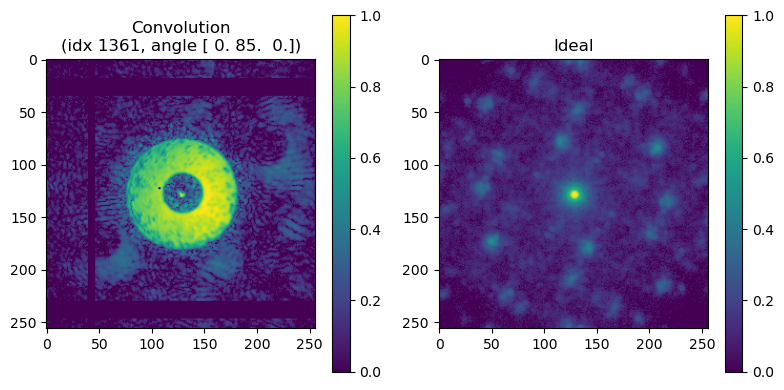

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Found 17 output peaks vs 20 ideal peaks
Found 16 output peaks vs 20 ideal peaks
Found 18 output peaks vs 20 ideal peaks
Found 17 output peaks vs 20 ideal peaks
Found 14 output peaks vs 20 ideal peaks
Found 15 output peaks vs 20 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1035: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


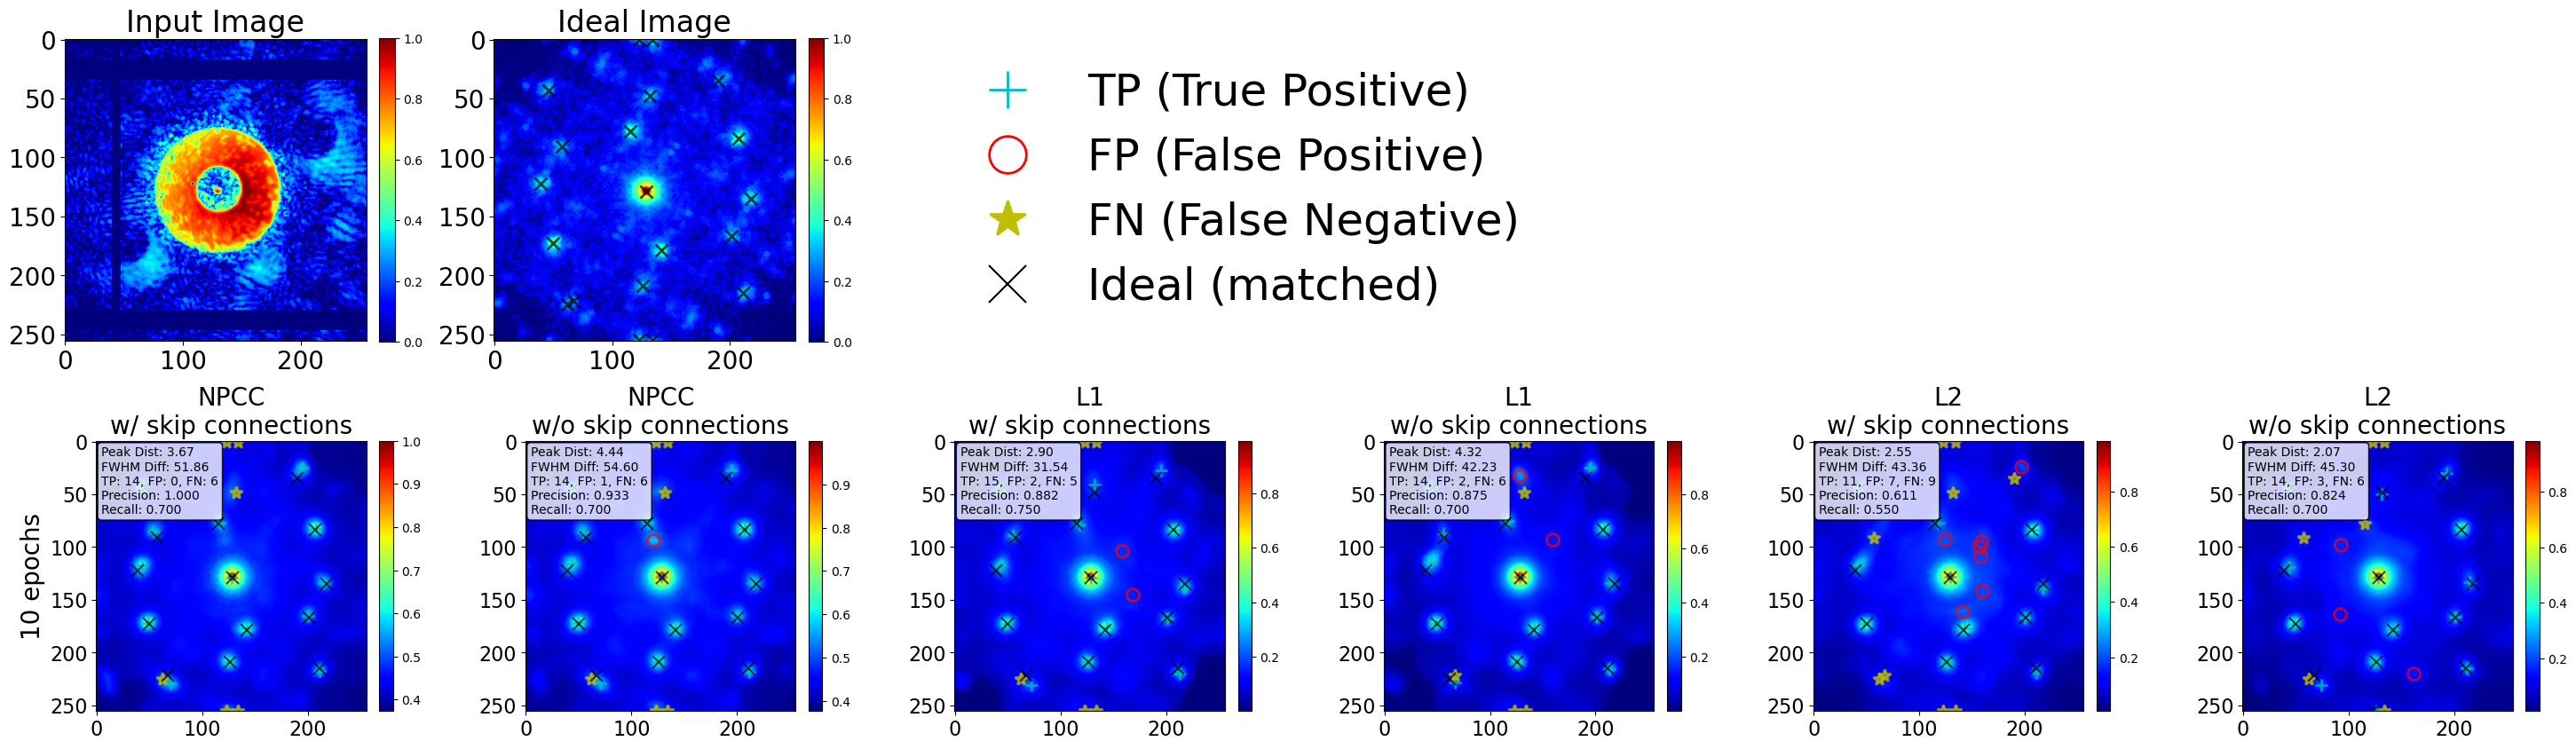

--------------------------------
ModelComparer class initialized successfully!
Using device: cuda
model_configs:  {'iterations': [25], 'models': {'pearson_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'pearson_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth', 'L1_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth', 'L1_no_Unet': '/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.

Plotting selected angle indices:   0%|          | 0/1 [00:00<?, ?it/s]

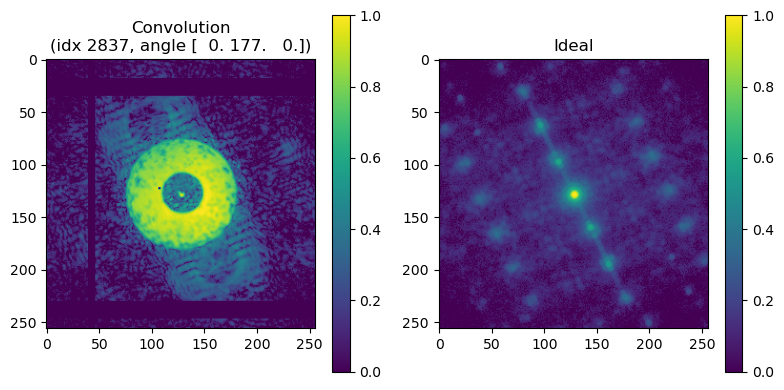

Plotting selected angle indices: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Found 14 output peaks vs 15 ideal peaks
Found 14 output peaks vs 15 ideal peaks
Found 13 output peaks vs 15 ideal peaks
Found 13 output peaks vs 15 ideal peaks
Found 14 output peaks vs 15 ideal peaks
Found 14 output peaks vs 15 ideal peaks


/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/src/utils/model_comparer.py:1035: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


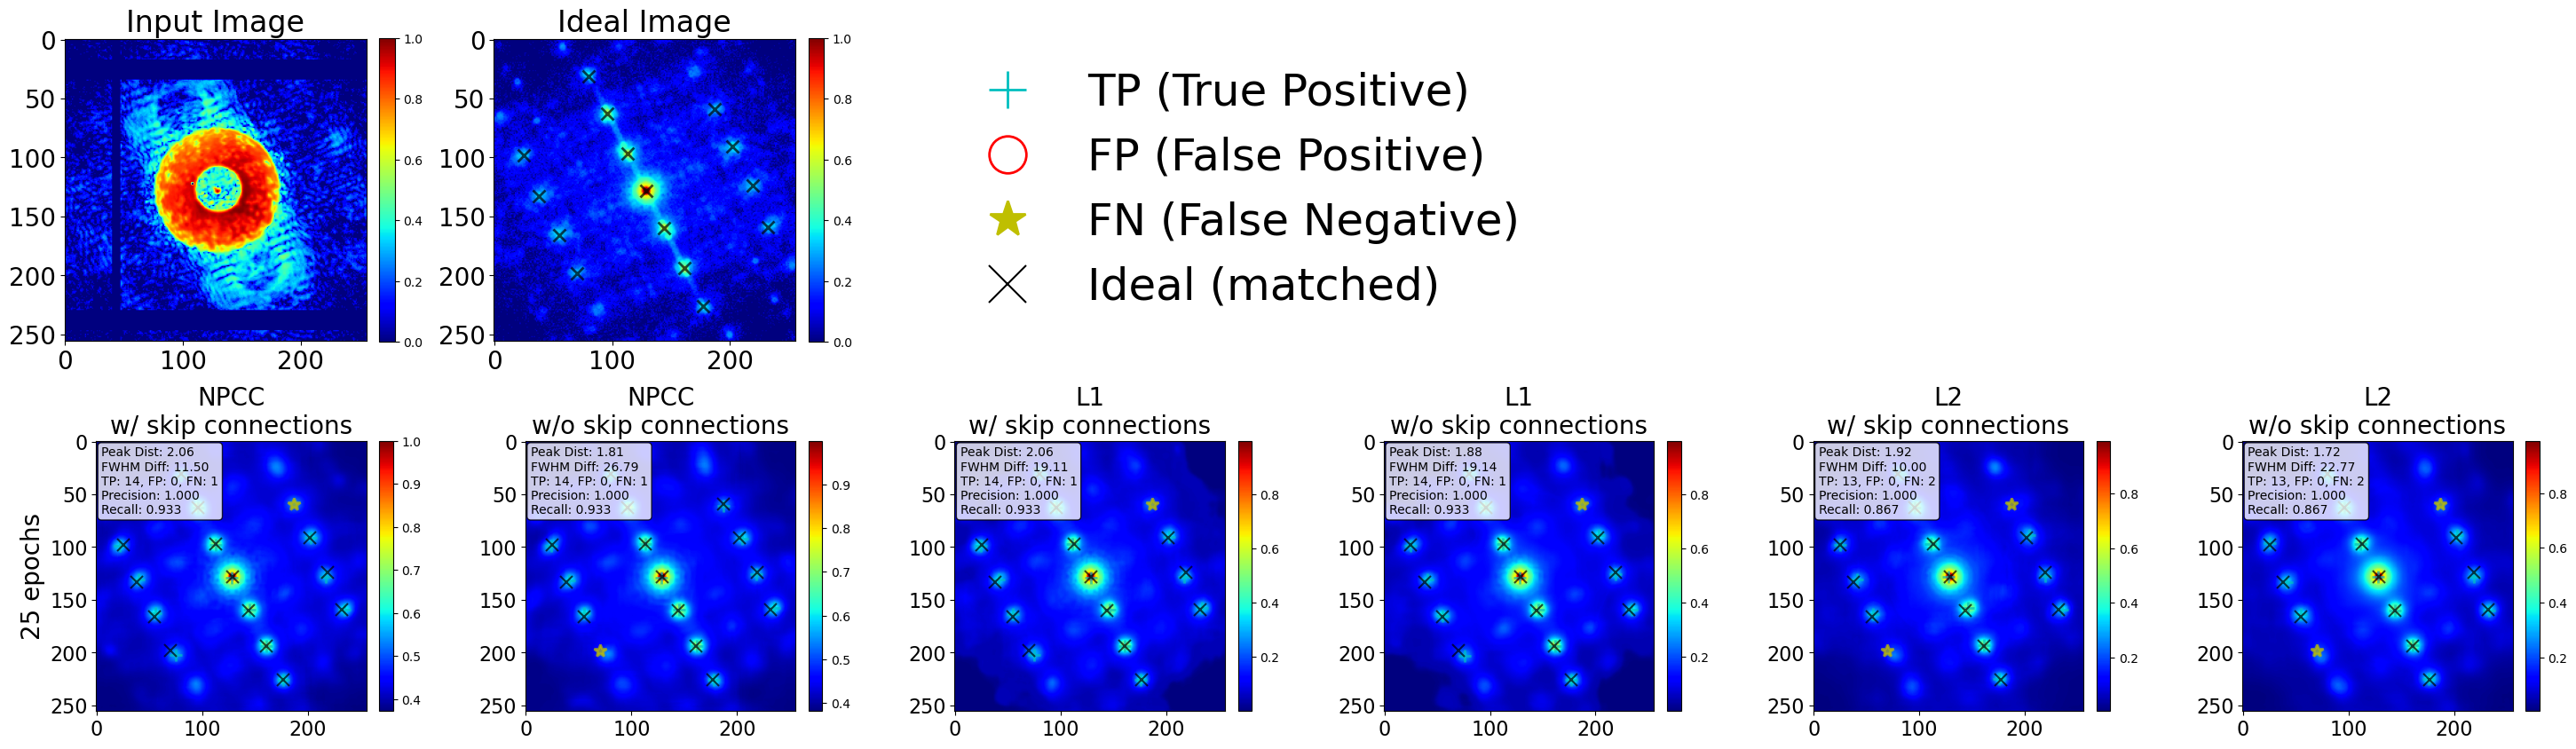

--------------------------------
Comparer peak parameters:
1.428
0.28355
12.0
1.0
96.0
True
--------------------------------


In [ ]:
files=[2,10,25]#,50,100,150,200,250]
stats_list = []
for epoch in files: 
    # Initialize the comparer
    comparer = ModelComparer()

    # Define model parameters
    probe_sizes=[256]#,256]#,128]
    lattice_types=['ClathII']#,'SC']#,'ClathII']
    unet_statuses=['Unet']#,'no_Unet']#,'no_Unet']#,'Unet']#,'no_Unet']
    loss_functions=['pearson_loss']#,'L1','L2']#,'L1','L2']
    noise_statuses=['Noise']#,'noNoise']#,'Noise']
    epochs=[epoch]#2,10,25,50,100,150,200,250,300,400,500]
    base_path="/net/micdata/data2/12IDC/ptychosaxs/"
    model_list=[base_path + f'batch_mode_250/trained_model/best_model_Lattice{lattice_type}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise_status}_sim_ZCB_9_3D_S5065_N600_steps4_dp256_{unet_status}_epoch_{epoch}_{loss_function}_symmetry_0.0.pth' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
    model_list_info =[f'Lattice{lattice_type}_Probe{probe_size}x{probe_size}_{noise_status}_{unet_status}_{loss_function}' for loss_function in loss_functions for unet_status in unet_statuses for lattice_type in lattice_types for probe_size in probe_sizes for noise_status in noise_statuses]
    # }

    model_configs = {
        'iterations': epochs,
        'models': {
            'pearson_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
            'pearson_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_pearson_loss_symmetry_0.0.pth',
            'L1_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L1_symmetry_0.0.pth',
            'L1_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L1_symmetry_0.0.pth',
            'L2_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_{}_L2_symmetry_0.0.pth',
            'L2_no_Unet': base_path + 'batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_no_Unet_epoch_{}_L2_symmetry_0.0.pth',
        }
    }

    print('--------------------------------')
    print("ModelComparer class initialized successfully!")
    print(f"Using device: {comparer.device}")
    print('model_configs: ', model_configs)
    print('Epoch: ', epoch)
    print('--------------------------------')

    # Load and plot selected angle indices from the .h5 file
    h5_file_path = "/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/tomo_tests/LatticeClathII_Probe256x256_Noise/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5"
    ri=random.randint(0, 179)
    #angle_indices = [ri]  # Modify as needed, e.g., [0, 1, 2] to plot more angles
    angle_indices = [ri] #61, WEAK DIFFRACTION #[51]# [135]#hex pattern    #[50]#strong diffraction        #[20]#weak diffraction pattern
    print(f"Selected angle index: {angle_indices}")
    mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
        
    with h5py.File(h5_file_path, 'r') as h5file:
        # Check that datasets exist
        if 'convDP' not in h5file:
            raise ValueError(f"Key 'convDP' not found in h5 file: {h5_file_path}")
        if 'pinholeDP_raw_FFT' not in h5file:
            raise ValueError(f"Key 'pinholeDP_raw_FFT' not found in h5 file: {h5_file_path}")

        convDP = h5file['convDP'][:]
        pinholeDP_raw_FFT = h5file['pinholeDP_raw_FFT'][:]
        rotation_angles = h5file['rotation_angles'][:] if 'rotation_angles' in h5file else None

        num_patterns = convDP.shape[0]
        num_angles = rotation_angles.shape[0] if rotation_angles is not None else 1

        # Determine the patterns per angle
        patterns_per_angle = num_patterns // num_angles if num_angles > 0 else num_patterns

        # Gather pattern indices corresponding to the selected angles
        selected_pattern_indices = []
        for angle_idx in angle_indices:
            start_idx = angle_idx * patterns_per_angle
            end_idx = min(start_idx + patterns_per_angle, num_patterns)
            selected_pattern_indices.extend(range(start_idx, end_idx))
        
        selected_scan_point = random.randint(0,16)
        selected_pattern_indices = selected_pattern_indices[selected_scan_point:selected_scan_point+1]#[2:3]#[0:1]

        # Plot results for each pattern of selected angles
        for pi in tqdm(selected_pattern_indices, desc="Plotting selected angle indices"):
            convDP_pattern = convDP[pi]
            pinholeDP_pattern = pinholeDP_raw_FFT[pi]
            
            dp_pp, _, _ = ptNN_U.preprocess_ZCB_9(convDP_pattern, mask)
            dp_pp_IDEAL, _, _ = ptNN_U.preprocess_ZCB_9(pinholeDP_pattern, mask=np.ones(dp_pp[0][0].shape))
            
            # If you want to use torch/cuda, adapt as needed (e.g., dp_pp = torch.tensor(...))
            dp_pp = comparer.ensure_tensor_format(dp_pp)
            dp_pp_IDEAL = comparer.ensure_tensor_format(dp_pp_IDEAL)

            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            im1 = ax[0].imshow(dp_pp.squeeze().cpu().numpy())
            im2 = ax[1].imshow(dp_pp_IDEAL.squeeze().cpu().numpy())
            plt.colorbar(im1, ax=ax[0])
            plt.colorbar(im2, ax=ax[1])
            ax[0].set_title(f'Convolution\n(idx {pi}, angle {rotation_angles[pi//patterns_per_angle] if rotation_angles is not None else "?"})')
            ax[1].set_title('Ideal')
            plt.tight_layout()
            plt.show()

    comparer.default_peak_sigma = 0.714*2
    comparer.default_peak_threshold = 0.265*1.07
    comparer.peak_distance_threshold = 12.0
    comparer.ideal_peak_smoothing_sigma = 1.0
    comparer.percentile_threshold_value = 96.
    comparer.output_percentile_threshold_value = comparer.percentile_threshold_value
    comparer.use_percentile_threshold = True

    # Create comparison grid
    fig = comparer.create_comparison_grid(
        model_configs=model_configs,
        base_path="/net/micdata/data2/12IDC/ptychosaxs/models/ZCB_9_3D/",
        input_data=dp_pp,
        ideal_data=dp_pp_IDEAL,
        figsize=(15, 15),
        calculate_psnr=False,
        calculate_ssim=False,
        calculate_xcorr=False,
        calculate_peaks=True,
        show_peak_classification=True,
    )
    plt.show()


print('--------------------------------')
print('Comparer peak parameters:')
print(comparer.default_peak_sigma)
print(comparer.default_peak_threshold)
print(comparer.peak_distance_threshold)
print(comparer.ideal_peak_smoothing_sigma)
print(comparer.percentile_threshold_value)
print(comparer.use_percentile_threshold)
print('--------------------------------')

In [ ]:
print('--------------------------------')
print('Comparer peak parameters:')
print(comparer.default_peak_sigma)
print(comparer.default_peak_threshold)
print(comparer.peak_distance_threshold)
print(comparer.ideal_peak_smoothing_sigma)
print(comparer.percentile_threshold_value)
print(comparer.use_percentile_threshold)
print('--------------------------------')
stats = comparer.calculate_cumulative_stats_from_h5(
model_configs=model_configs,
h5_file_path="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/tomo_tests/LatticeClathII_Probe256x256_Noise/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5",
base_path="/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/",
calculate_peaks=True,
angle_indices=angle_indices,#list(range(0,180)),#sorted(random.sample(range(0, 180), 9)),#list(range(0,180,20)),#[0,45,90,135]
show_peak_classification=True,
)

comparer.print_cumulative_stats(stats, sort_by='avg_peak_precision')  # Sort by SSIM
comparer.print_cumulative_stats(stats, sort_by='peak_detection_rate')  # Sort by peak detection rate
comparer.print_cumulative_stats(stats, sort_by='avg_peak_f1')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='avg_peak_recall')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_tp')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_fp')  # Sort by PSNR
comparer.print_cumulative_stats(stats, sort_by='total_peak_fn')  # Sort by PSNR

stats_list.append(stats)


print('--------------------------------')
print('--------------------------------')
print('--------------------------------')
print('--------------------------------')
print('--------------------------------')